In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import random
import gerrychain
from gerrychain import (
    Graph,
    Partition,
    proposals,
    updaters,
    constraints,
    accept,
    MarkovChain,
)
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
from utils import plot_on_map
from tqdm import tqdm

In [2]:
mo_bg = Graph.from_json("data/mo-bg-connected.json")

In [3]:
mo_bg.nodes[0].keys()

dict_keys(['boundary_node', 'area', 'WPOP20', 'INTPTLON20', 'AWATER20', 'FILEID', 'TRACTCE20', 'CIFSN', 'APAMIPOP20', 'APBVAP20', 'ALAND20', 'NHPIPOP20', '2MOREVAP20', 'AMINPOP20', 'ASIANPOP20', 'STUSAB', 'TOTPOP20', 'ASIANVAP20', 'BLKGRPCE20', 'NWBHPOP20', 'APBPOP20', 'MTFCC20', 'APAVAP20', 'NHPIVAP20', 'NAMELSAD20', 'GEOID20', 'BVAP20', 'WVAP20', 'CHARITER', 'APAMIVAP20', 'STATEFP20', 'OTHERVAP20', 'APAPOP20', 'FUNCSTAT20', 'VAP20', 'BPOP20', 'COUNTYFP20', 'DOJBVAP20', 'NWBHVAP20', 'LOGRECNO', 'GEOCODE', '2MOREPOP20', 'OTHERPOP20', 'HVAP20', 'INTPTLAT20', 'SUMLEV', 'HISP20', 'AMINVAP20'])

In [4]:
POPULATION_KEY = "TOTPOP20"

total_population = sum(mo_bg.nodes[n][POPULATION_KEY] for n in mo_bg.nodes)

In [5]:
num_dist = 8
ideal_population = total_population / num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(
    mo_bg, range(num_dist), ideal_population, "TOTPOP20", pop_tolerance, 10
)

/Users/mschulist/miniconda3/envs/cse217a/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


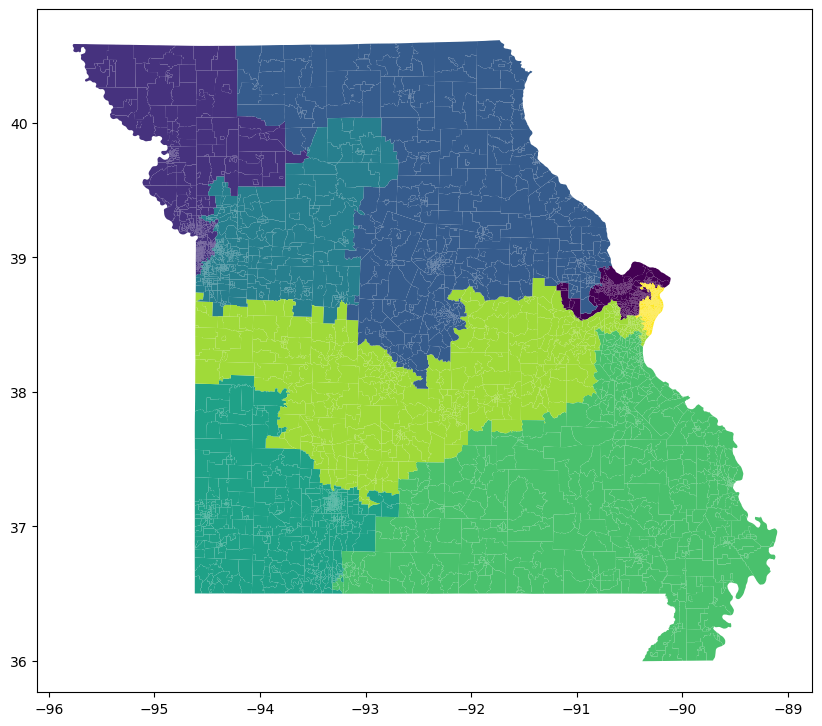

In [6]:
plot_on_map(mo_bg, initial_plan, "MO")

In [7]:
BLACK_POPULATION_KEY = "BPOP20"

initial_partition = Partition(
    mo_bg,
    assignment=initial_plan,
    updaters={
        "our cut edges": cut_edges,
        "district population": Tally(POPULATION_KEY, alias="district population"),
        "district BPOP": Tally(BLACK_POPULATION_KEY, alias="district BPOP"),
    },
)

In [8]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, pop_tolerance, pop_key="district population"
)

In [9]:
rw_proposal = partial(
    recom,
    pop_col=POPULATION_KEY,
    pop_target=ideal_population,
    epsilon=pop_tolerance,
    node_repeats=10,
)

random_walk = MarkovChain(
    proposal=rw_proposal,
    constraints=[population_constraint],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=20,
)

population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, pop_tolerance, pop_key="district population"
)

total_steps = 50
our_random_walk = MarkovChain(
    proposal=rw_proposal,
    constraints=[population_constraint],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=total_steps,
)

KeyboardInterrupt: 

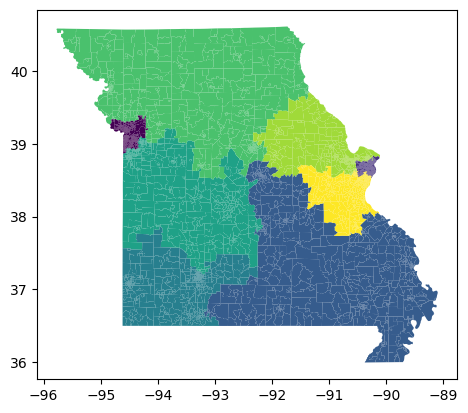

In [10]:
from IPython import display
import warnings

warnings.filterwarnings("ignore")

cutedge_ensemble = []
bmaj_ensemble = []

fig, ax = plt.subplots()

for part in our_random_walk:
    cutedge_ensemble.append(len(part["our cut edges"]))
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = part["district BPOP"][i] / part["district population"][i]
        if b_perc >= 0.4:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Update the plot on the same axes
    plot_on_map(mo_bg, part.assignment, "MO", ax)

    # Clear and display the updated plot
    display.clear_output(wait=True)
    display.display(fig)

plt.show()

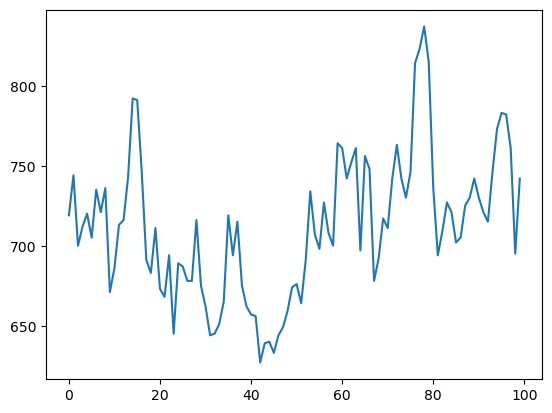

In [32]:
plt.plot(cutedge_ensemble)